### Imports

In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib
%matplotlib inline
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Constants

In [2]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'
POPULATION_FILE = 'population.csv'
IHD_FILE = 'ihd.csv'
JSON_COUNTRIES_FILE = 'world-countries.json'
COUNTRIES_CONTINENTS = 'countries_continents.csv'

### Read Data

In [73]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)
ihd = pd.read_csv(DATA_FOLDER + '/' + IHD_FILE, low_memory=False)
population = pd.read_csv(DATA_FOLDER + '/' + POPULATION_FILE, low_memory=False)
countries_shapes = pd.read_json(DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, orient='columns')
countries_continents = pd.read_csv(DATA_FOLDER + '/' + COUNTRIES_CONTINENTS, low_memory=False, index_col='Code')

### Analyse the different datasets

### Open Food Facts 

In [41]:
data = all_datas.copy()
data.shape

(685395, 173)

We can see that open food facts has 173 features. This is a lot of information!
We have to select only the features which could help us to answer our questions. 
We would like to see the number of entries per features, to see which would have enough samples for our data, once all NaN values of a row are dropped.

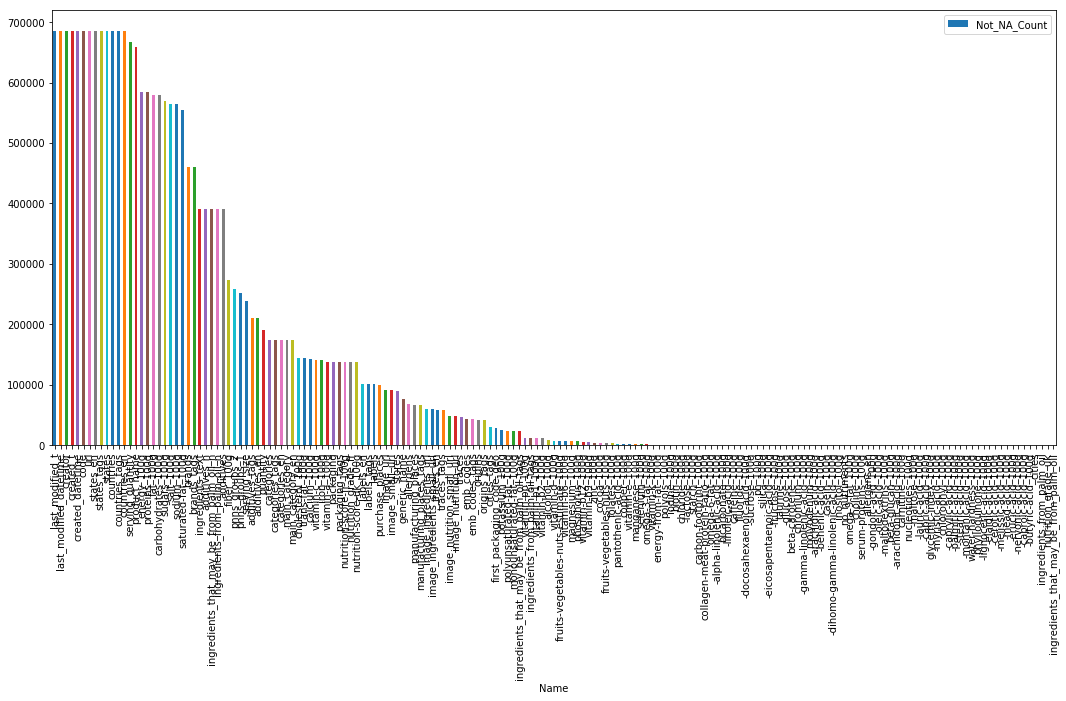

In [40]:
not_na = []
#for each feature in our dataset
for c in data.columns.values: 
    #count na values per feature
    count = data[c].notna().sum()
    not_na.append((c, count))
#create df with feature name and number of valid entries
df = pd.DataFrame(not_na, columns=['Name','Not_NA_Count'])
#sort
df.sort_values(by='Not_NA_Count', inplace=True, ascending=False)
df = df.reset_index(drop=True)
#plot
df.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,8))

We can see that although there are many available features, over half of them have a very small amount of entries. 

Let's plot a graph with a threshold on the amount of entries, i.e. 10000

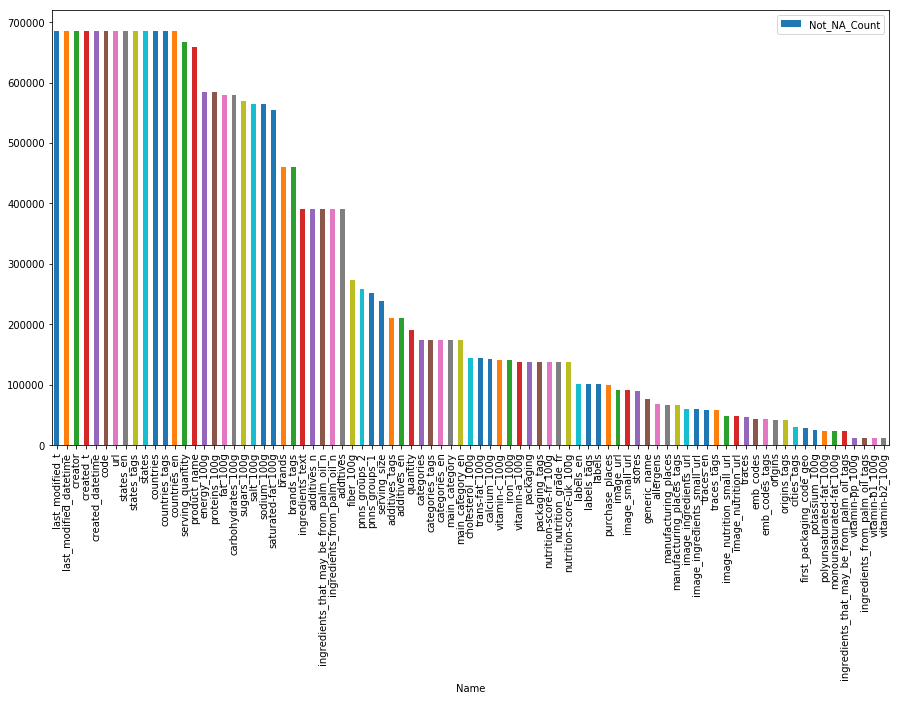

In [21]:
threshold = 10000
df[df['Not_NA_Count'] > threshold].plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(15,8))

This is already better, but we can see that there are a lot of features that are not useful to us (i.e. last_modified_t, creator, url, states, ...). 

We have thus selected features that we judge will be interesting to look at later on in our study

In [37]:
features = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g',
            'energy_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g',
            'saturated-fat_100g','ingredients_text', 'fiber_100g','serving_size', 'additives_en']

In [43]:
data[features].dropna().shape

(98828, 15)

If we drop all rows with NaN values, we still have a sample of 98828 entries, which we judge to be sufficient.

Features that will be useful to our study:
 - product_name: name of product
 - countries/countries_tags:  list of countries where the product is sold
 - sugars_100g, fat_100g, energy_100g, carbohydrates_100g, proteins_100g, salt_100g, sodium_100g , saturated-fat_100g, fiber_100g: the amount of a nutriment (in g, or kJ for energy) for 100 g
 - ingredients_text: ingredients contained in the product
 - additives_en: additives found in the product


We have spotted that there will be some work to do in order to group products by countries, since some products are sold in many countries. The countries_tags consist of a list of countries, with a language tag followed by the country name (in said language).
For example:

In [60]:
data['countries_tags'].value_counts()[150:160]

en:france,en:portugal,en:spain               25
en:france,en:united-arab-emirates            24
en:france,en:switzerland,en:united-states    24
en:france,en:spain,en:switzerland            24
en:belgium,en:switzerland                    24
en:latvia                                    23
en:poland,en:united-kingdom                  23
en:france,en:germany,en:en                   23
en:france,en:india                           22
en:france,en:mexico                          22
Name: countries_tags, dtype: int64

This is why we have a dataset associating country names (in different languages) with their alpha codes.

### Countries

As stated above, this dataset associates a country name in a certain language, with the language tag, the alpha 2/3 code and the numeric code. 
We will use it to group the countries of the food data together.

In [66]:
countries_infos.shape

(20169, 6)

In [62]:
countries_infos.head()

,LANG,LANG_NAME,COUNTRY_ALPHA2_CODE,COUNTRY_ALPHA3_CODE,COUNTRY_NUMERIC_CODE,COUNTRY_NAME
0,AF,AFRIKAANS,AD,AND,20,Andorra
1,AF,AFRIKAANS,AE,ARE,784,Verenigde Arabiese Emirate
2,AF,AFRIKAANS,AF,AFG,4,Afganistan
3,AF,AFRIKAANS,AG,ATG,28,Antigua en Barbuda
4,AF,AFRIKAANS,AI,AIA,660,Anguilla


### Countries/Continents
Association of countries (alpha 2 code) with their continent code
[https://dev.maxmind.com/geoip/legacy/codes/country_continent/]

In [75]:
countries_continents.head()

,Continent
Code,
AD,EU
AE,AS
AF,AS
AG,NaN
AI,NaN


### Countries Shapes
Json file associating a country with its border coordinates. 
This will be used to display maps.
Example:
```json
{
    "type":"Feature",
    "properties":{"name":"Afghanistan"},
    "geometry":{"type":"Polygon","coordinates":[[[61.210817,35.650072],...,[61.210817,35.650072]]]},
    "id":"AFG"
}
```

### Overweight
This data indicates the population percentage which is overweight, for a certain country and by year.

We choose to work only with the last year of the database (2016).

In [67]:
overweight.shape

(8022, 4)

In [64]:
overweight.head()

,Entity,Code,Year,Indicator
0,Afghanistan,AFG,1975,0.5
1,Afghanistan,AFG,1976,0.5
2,Afghanistan,AFG,1977,0.6
3,Afghanistan,AFG,1978,0.6
4,Afghanistan,AFG,1979,0.6


###  Diabetes
Prevalence of diabetes per category and per country for the year 2017.
We will only look at the country/territory and Diabetes [18-99] national prevalence[%]

In [68]:
diabetes.shape

(221, 23)

In [65]:
diabetes.head()

,country_id,country/territory,idf_reg,"Adults with diabetes[18-99] in 1,000s",prev,Unnamed: 5,"Adults with diabetes confidence interval in 1,000s Min","Adults with diabetes confidence interval in 1,000s Max",Diabetes [18-99] national prevalence[%],Diabetes National prevalence confidence interval Min,...,Diabetes age-adjusted comparative prevalence confidence interval Max,"Undiagnosed diabetes [18-99] in 1,000",Undiagnosed diabetes confidence interval Min,Undiagnosed diabetes confidence interval Max,Mean Expenditure per person with diabetes (18-99) USD,Mean Expenditure per person with diabetes (18-99) ID,Diabetes related deaths (20-99),Diabetes related deaths confidence interval Min,Diabetes related deaths confidence interval Max,Data source of Diabetes prevalence estimates: extrapolation which countries
0,1,Afghanistan,MENA,1054.460430,0.061482,NaN,840.613890,1494.825185,6.15%,4.90%,...,13.80%,733.870351,585.040076,1040.349976,115.0,338.0,20960.044220,16688.839490,28361.868260,Islamic Republic of Iran
1,2,Albania,EUR,267.266724,0.119302,NaN,232.694171,304.292989,11.93%,10.39%,...,11.29%,108.610335,94.560937,123.656858,369.0,832.0,2845.686077,2536.877271,3189.789573,"Croatia, Cyprus,Greece, Slovenia,Turkey"
2,3,Algeria,MENA,1884.558775,0.068824,NaN,1247.936183,2629.709395,6.88%,4.56%,...,9.34%,1239.097394,820.518040,1729.033927,567.0,1461.0,15935.260820,8224.120172,21417.754870,NaN
3,4,Andorra,EUR,7.219999,0.127023,NaN,6.118940,9.315789,12.70%,10.77%,...,10.71%,2.581379,2.187715,3.330690,4431.0,5053.0,32.195171,27.947857,39.597543,"Portugal, Spain"
4,5,Angola,AFR,359.075986,0.029196,NaN,217.039437,576.950839,2.92%,1.76%,...,5.86%,178.444879,107.858998,286.719042,381.0,507.0,6256.612054,3802.686528,9739.760748,"Botswana, Mozambique, South Africa, Zimbabwe"


### Ischaemic  Heart   Disease
Number of deaths (in thousands) of IHD per country, for the year 2008. 
It was really hard to find official medical data, so even it is a decade ago, we are still interested in the trend. 

In [69]:
ihd.shape

(174, 2)

In [70]:
ihd.head()

,Country,IHD
0,USA,445.8
1,Germany,155.8
2,Japan,105.5
3,United Kingdom,92.3
4,Italy,87.8


### Population
Country population for the year 2008. 

In [72]:
population.shape

(236, 2)

In [71]:
population.head()

,Country,Population
0,China,1321851888
1,India,1129866154
2,European Union,490426060
3,United States,301139947
4,Indonesia,234693997


### Cleaning the Data
We clean our datasets. 

We do some operations on the countries tags to be able to parse the data. We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics!

In [5]:
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME', 'COUNTRY_ALPHA3_CODE']]
countries_infos = countries_infos.merge(countries_continents, left_on='COUNTRY_ALPHA2_CODE', right_index=True)
countries_infos['Continent'] = countries_infos['Continent'].replace(np.nan, 'NA', regex=True)

In [6]:
usefull_datas = all_datas.copy()

to_keep = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g','serving_quantity'
           ,'energy_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g','saturated-fat_100g','ingredients_text', 
           'additives',  'fiber_100g','serving_size', 'additives_en']
usefull_datas = usefull_datas[to_keep]
usefull_datas['countries_tags'] = usefull_datas['countries_tags'].replace(regex=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'-', value=r' ')
usefull_datas['countries'] = usefull_datas['countries'].apply(lambda x: str(x).lower())
usefull_datas = usefull_datas[usefull_datas['sugars_100g'] <= 100]
usefull_datas = usefull_datas[usefull_datas['fat_100g'] <= 100]
#get a feel of the data
usefull_datas.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en
0,Vitória crackers,france,france,15.0,7.0,0,1569.0,70.1,7.8,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN
2,Sauce Sweety chili 0%,france,france,0.4,0.0,0,88.0,4.8,0.2,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN
4,Salade de carottes râpées,france,france,3.9,0.3,0,134.0,5.3,0.9,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN
5,Fromage blanc aux myrtilles,france,france,16.3,4.9,0,540.0,16.3,4.4,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN
8,Baguette parisien,france,france,1.8,3.3,0,929.0,38.4,11.7,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN


In [4]:
#for col in all_datas.columns.values:
#    print("- ", col)

We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [7]:
countries = []

for c in usefull_datas['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.lower()
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name and country code
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE'], c_i['Continent']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [8]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)

In [9]:
to_append = [('united-states', 'US', 'NA'), ('united-kingdom', 'UK', 'EU'), ('french-polynesia', 'PF', 'OC'),
             ('hong-kong', 'HK', 'AS'), ('new-zealand', 'NZ', 'OC'), ('new-caledonia', 'NC', 'OC'),
             ('scotland','GB', 'EU'), ('united-arab-emirates', 'AE', 'AS'), ('etats-unis', 'US', 'NA'),
             ('czech-republic', 'CZ', 'EU'), ('south-africa', 'ZA', 'AF'), ('quebec', 'CA', 'NA'), 
             ('saint-pierre-and-miquelon', 'FR', 'NA'),('french-guiana', 'FR', 'SA'), 
             ('south-korea', 'KR', 'AS')]
for i in to_append:
    proper_countries.append(i)

In [10]:
proper_countries[0:5]

[('france', 'FR', 'EU'),
 ('canada', 'CA', 'NA'),
 ('oman', 'OM', 'AS'),
 ('germany', 'DE', 'EU'),
 ('belgium', 'BE', 'EU')]

When a rows mention many countries we explode the dataframe to get one line for each country.

In [11]:
def explode(df):
    rows = []
    for index, data in df.iterrows():
        countries = str(data['countries_tags']).split(',')
        for country in countries:
            data['countries'] = country
            rows.append(data)
    return pd.DataFrame(rows)

In [12]:
exploded_data = explode(usefull_datas)

In [13]:
def get_tag(row, col1, col2, col3):
    for c in proper_countries:
        if c[0] == row[col1]:
            row[col2] = c[1]
            row[col3] = c[2]
            return row
    row[col2] = "TBD"
    row[col3] = "TBD"
    return row

In [14]:
exploded_data['continent'] = ''
parsed_datas = exploded_data.apply(lambda x: get_tag(x, 'countries', 'countries_tags', 'continent'), axis=1)

In [15]:
parsed_datas.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en,continent
0,Vitória crackers,france,FR,15.0,7.0,0,1569.0,70.1,7.8,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN,EU
2,Sauce Sweety chili 0%,france,FR,0.4,0.0,0,88.0,4.8,0.2,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN,EU
4,Salade de carottes râpées,france,FR,3.9,0.3,0,134.0,5.3,0.9,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN,EU
5,Fromage blanc aux myrtilles,france,FR,16.3,4.9,0,540.0,16.3,4.4,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN,EU
8,Baguette parisien,france,FR,1.8,3.3,0,929.0,38.4,11.7,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN,EU


### Get results
Now we compute result from the parsed datasets. We would like to get the mean average of sugar and fat per 100g per country.

In [16]:
grouped = parsed_datas.groupby(['countries_tags'])
means = grouped.mean()
med = grouped.median()
counted = grouped.count()

### TODO Normalize data???

In [17]:
parsed_datas.reset_index(drop=True).head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en,continent
0,Vitória crackers,france,FR,15.0,7.0,0,1569.0,70.1,7.8,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN,EU
1,Sauce Sweety chili 0%,france,FR,0.4,0.0,0,88.0,4.8,0.2,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN,EU
2,Salade de carottes râpées,france,FR,3.9,0.3,0,134.0,5.3,0.9,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN,EU
3,Fromage blanc aux myrtilles,france,FR,16.3,4.9,0,540.0,16.3,4.4,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN,EU
4,Baguette parisien,france,FR,1.8,3.3,0,929.0,38.4,11.7,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN,EU


In [18]:
#parsed_datas.drop(columns=['product_name'], inplace=True)
#features = ['countries_tags','sugars_100g','fat_100g','serving_quantity'
#           ,'energy_100g','carbohydrates_100g','proteins_100g','salt_100g','sodium_100g','saturated-fat_100g',
#           'additives',  'fiber_100g','serving_size', 'additives_en']
#train = pd.get_dummies(parsed_datas[features])

### Sets
We define sets by continents to look at correlations later on

In [19]:
asia = parsed_datas[parsed_datas['continent'] == 'AS']
africa = parsed_datas[parsed_datas['continent'] == 'AF']
oceania = parsed_datas[parsed_datas['continent'] == 'OC']
europe = parsed_datas[parsed_datas['continent'] == 'EU']
north_america = parsed_datas[parsed_datas['continent'] == 'NA']
south_america = parsed_datas[parsed_datas['continent'] == 'SA']

In [22]:
def median_mean_grouped(df, group_by):
    grouped = df.groupby([group_by])
    median = grouped.median()
    #med['continent'] = ""
    #med = med.apply(lambda x: get_continent(x, df), axis=1)
    mean = grouped.mean()
    #mean['continent'] = ""
    #mean = mean.apply(lambda x: get_continent(x, df), axis=1)
    return median, mean

In [23]:
asia_med, asia_mean = median_mean_grouped(asia, 'countries_tags')
africa_med, africa_mean = median_mean_grouped(africa, 'countries_tags')
oceania_med, oceania_mean = median_mean_grouped(oceania, 'countries_tags')
europe_med, europe_mean = median_mean_grouped(europe, 'countries_tags')
na_med, na_mean = median_mean_grouped(north_america, 'countries_tags')
sa_med, sa_mean = median_mean_grouped(south_america, 'countries_tags')

In [24]:
mean = [means, africa_mean, asia_mean, europe_mean, na_mean, sa_mean, oceania_mean]
median = [med, africa_med, asia_med, europe_med, na_med, sa_med, oceania_med]
rows = [parsed_datas.shape[0], africa.shape[0], asia.shape[0], europe.shape[0], 
        north_america.shape[0], south_america.shape[0], oceania.shape[0]]
continent = ['ALL', 'AF', 'AS', 'EU', 'NA', 'SA', 'OC']
columns = ['Continent','Pearson', 'Kendall', 'Spearman']

In [25]:
#re add continent to means/medians df
for i in range(1,len(mean)):
    mean[i]['continent'] = continent[i]
    median[i]['continent'] = continent[i]

### Sugar

In [31]:
#sugar_means = means[['sugars_100g']].dropna()
#remove outliers
#sugar_means = sugar_means[sugar_means['sugars_100g'] <= 100]
#we would like to have countries with a big enough sample of values in the database, we choose 20 for now
#sugar_means = sugar_means[counted['sugars_100g'] > 20]
#sort values
#sugar_means.sort_values(by=['sugars_100g'], ascending=False, inplace=True)

In [32]:
#def plot_mean_med(df1, df2):
#    f, ax = plt.subplots(nrows=2)
#    a = df1.plot.bar(figsize=(15,5), ax=ax[0], title='Mean')
#    b = df2.plot.bar(figsize=(15,5), ax=ax[1], title='Median')
#    plt.tight_layout()
#    plt.show()

In [33]:
#plot_mean_med(sugar_means, sugar_med)

We can see which countries consume the most sugars according to our datas.

In [34]:
#sugar_med = med[['sugars_100g']].dropna()
#remove outliers
#sugar_med = sugar_med[sugar_med['sugars_100g'] <= 100]
#we would like to have countries with a big enough sample of values in the database, we choose 20 for now
#sugar_med = sugar_med[counted['sugars_100g'] > 20]
#sort values
#sugar_med.sort_values(by=['sugars_100g'], ascending=False, inplace=True)

#remove null values
#fat = means[['fat_100g']].dropna()
#remove outliers
#fat = fat[fat['fat_100g'] <= 100]
#remove values with small sample
#fat = fat[counted['fat_100g'] > 20]
#sort
#fat.sort_values(by=['fat_100g'], ascending=False, inplace=True)
#fat.plot.bar(figsize=(15,10))

In [35]:
def corr(df, x_, y_, continent, avg):
    pearson = df.corr(method='pearson')[x_][y_]
    kendall = df.corr(method='kendall')[x_][y_]
    spearman = df.corr(method='spearman')[x_][y_]
    return [continent,pearson, kendall, spearman]

In [36]:
def plt_corr(df1, df2, continent, avg1, avg2, x_, y_, title_):
    f, ax = plt.subplots(ncols=2, sharey=True)
    a =  df1.plot(kind='scatter',x=x_,y=y_, title= continent + " : " + avg1 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[0])
    b =  df2.plot(kind='scatter',x=x_,y=y_, title=continent + " : " + avg2 +" : "+ title_, figsize=(8,4),grid=True, ax=ax[1])
    plt.tight_layout()
    plt.show()
    corrs_avg1 = corr(df1, x_, y_, continent, avg1)
    corrs_avg2 = corr(df2, x_, y_, continent, avg2)
    return corrs_avg1, corrs_avg2

In [37]:
def plot(dfs_1, dfs_2, continents, avg1, avg2, x_, y_, title_, columns_):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(mean)
    f, ax = plt.subplots(ncols=2, nrows=(nb_rows + 1), figsize=(10, 30))
    for i in range(nb_rows):
        a = dfs_1[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg1 +" : "+ title_, ax=ax[i][0])
        b = dfs_2[i].plot(kind='scatter',x=x_,y=y_, title= continent[i] + " : " + avg2 +" : "+ title_, ax=ax[i][1])
        c_1 = corr(dfs_1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs_2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[nb_rows][0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[nb_rows][1], title = 'Correlations : ' + avg2)
    plt.tight_layout()
    plt.show()
    display(corr1.merge(corr2, left_on='Continent', right_on='Continent', suffixes=['_Mean', '_Median']))
    #display(corr2)
    #return corr1, corr2

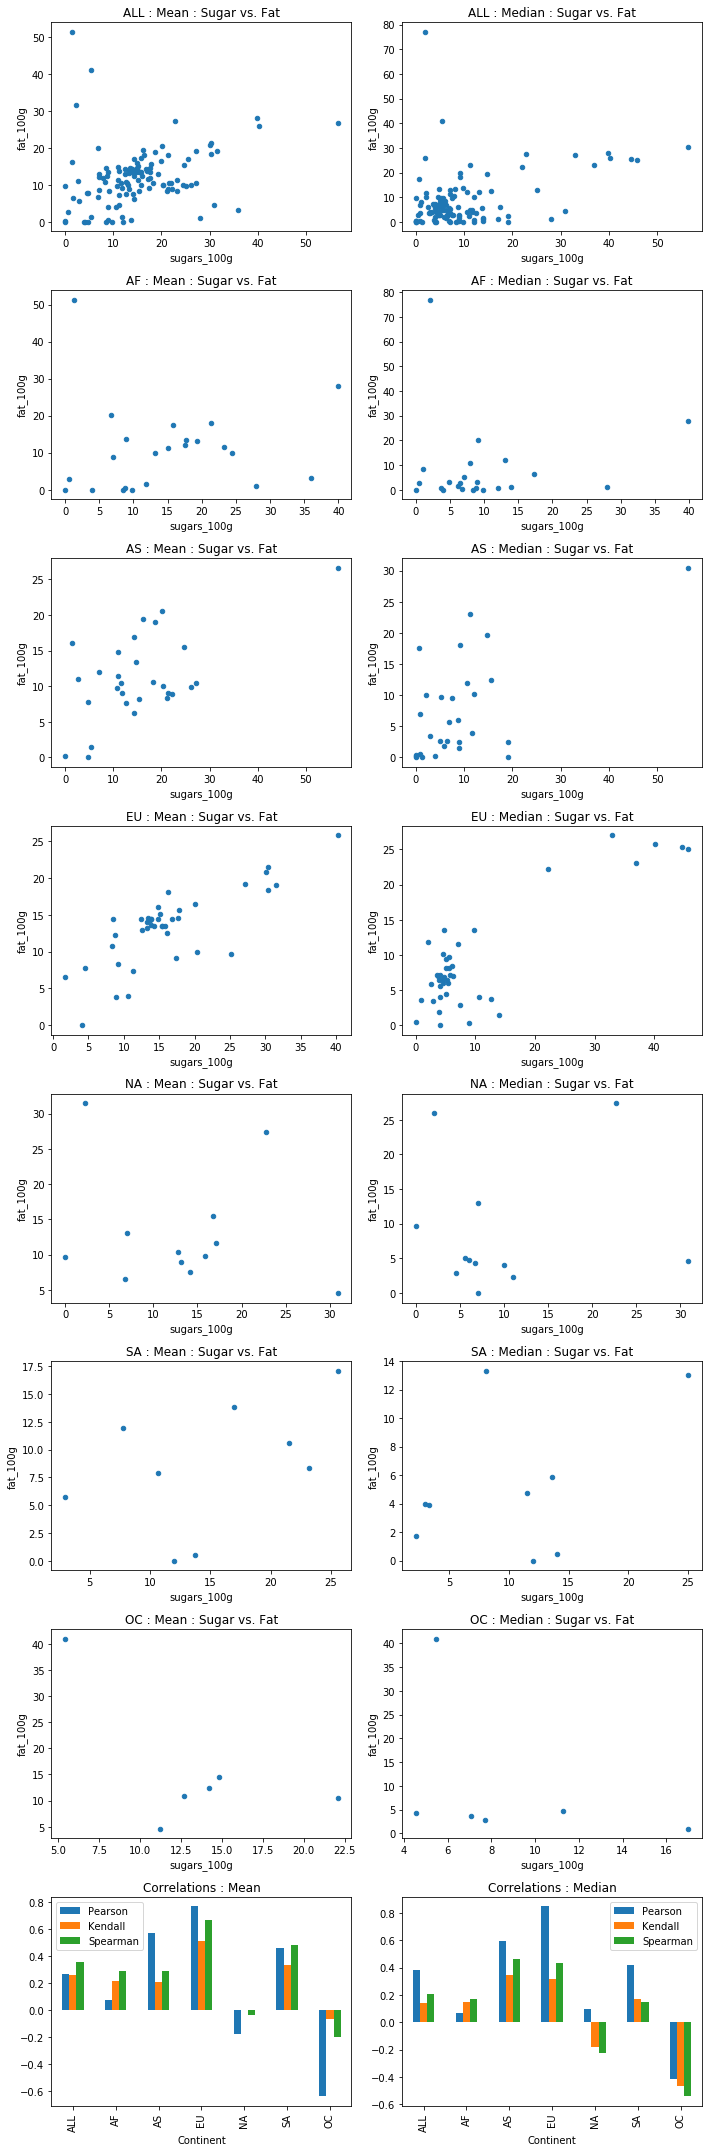

,Continent,Pearson_Mean,Kendall_Mean,Spearman_Mean,Pearson_Median,Kendall_Median,Spearman_Median
0,ALL,0.264659,0.259809,0.353926,0.381403,0.141381,0.206419
1,AF,0.071977,0.212015,0.293215,0.065007,0.148614,0.167989
2,AS,0.575162,0.211823,0.292611,0.598250,0.344488,0.462411
3,EU,0.770319,0.512195,0.672648,0.848419,0.316954,0.434741
4,NA,-0.176158,0.000000,-0.034965,0.100695,-0.181818,-0.223776
5,SA,0.462596,0.333333,0.483333,0.419887,0.166667,0.150000
6,OC,-0.641905,-0.066667,-0.200000,-0.412081,-0.466667,-0.542857


In [38]:
plot(mean, median, continent, 'Mean', 'Median', 'sugars_100g', 'fat_100g', 'Sugar vs. Fat', columns)

### TODO
#### Simpson's paradox: Europe, Asia
#### Description

In [41]:
#indexes = pd.DataFrame(np.concatenate((sugar.index.values,fat.index.values)))
#indexes = indexes.drop_duplicates()

In [42]:
def merge_all(dfs, merge_with, left_on_='countries_tags', right_on_='code', right_index=False):
    merged = []
    for i in dfs:
        if right_index:
            merged.append(i.merge(merge_with, left_on=left_on_, right_index=True))
        else:
            merged.append(i.merge(merge_with, left_on=left_on_, right_on=right_on_))
    return merged

In [128]:
def sns_plt(df1, df2, x_, y_, hue_, avg1, avg2, title_):
    fig, ax = plt.subplots(nrows=2)
    ax[0].set_title(avg1 + " : " + title_)
    ax[1].set_title(avg2 + " : " + title_)
    #sns.set(style="ticks", rc={'figure.figsize':(10, 6)})
    sns.scatterplot(x=x_, y=y_, data=df1, hue=hue_, ax=ax[0])
    sns.scatterplot(x=x_, y=y_, data=df2, hue=hue_, ax=ax[1])
    plt.tight_layout()
    plt.show()

In [76]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: x.lower().replace(' ', '-'))
#get country codes
overweight_datas = overweight_datas.apply(lambda x: get_tag(x, 'Entity', 'Code', 'continent'), axis=1)
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Code'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Code'])
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)
indices = parsed_datas['countries_tags'].drop_duplicates().values
overweight_datas = overweight_datas[overweight_datas.index.isin(indices)]
overweight_datas = overweight_datas.rename(columns={'Indicator':'Overweight Prevalence'})
overweight_datas.index.name = 'countries_tags'

In [77]:
mean_overweight = merge_all(mean, overweight_datas, right_index=True)
median_overweight = merge_all(median, overweight_datas, right_index=True)

In [88]:
def show_corr(dfs1, dfs2, x_, y_, avg1, avg2, columns_, continent):
    corrs_avg1 = []
    corrs_avg2 = []
    nb_rows = len(mean)
    for i in range(nb_rows):
        c_1 = corr(dfs1[i], x_, y_, continent[i], avg1)
        c_2 = corr(dfs2[i], x_, y_, continent[i], avg2)
        corrs_avg1.append(c_1)
        corrs_avg2.append(c_2)
    f, ax = plt.subplots(ncols=2, figsize=(16, 8))
    corr1 = pd.DataFrame(corrs_avg1, columns = columns_)
    corr2 = pd.DataFrame(corrs_avg2, columns = columns_)
    c = corr1.plot.bar(x = 'Continent', ax=ax[0], title = 'Correlations : ' + avg1)
    d = corr2.plot.bar(x = 'Continent', ax=ax[1], title = 'Correlations : ' + avg2)
    plt.show()
    display(corr1.merge(corr2, left_on='Continent', right_on='Continent', suffixes=['_Mean', '_Median']))

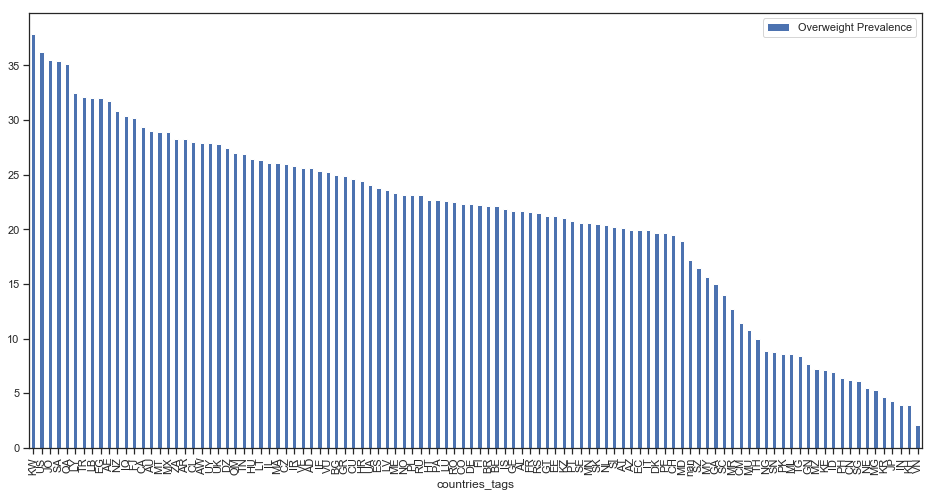

In [89]:
overweight_datas.plot.bar(figsize=(16,8))

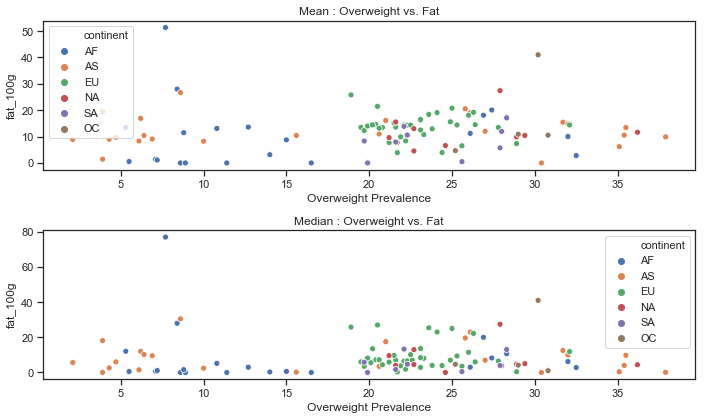

In [129]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 
        'Overweight Prevalence', 'fat_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Fat')

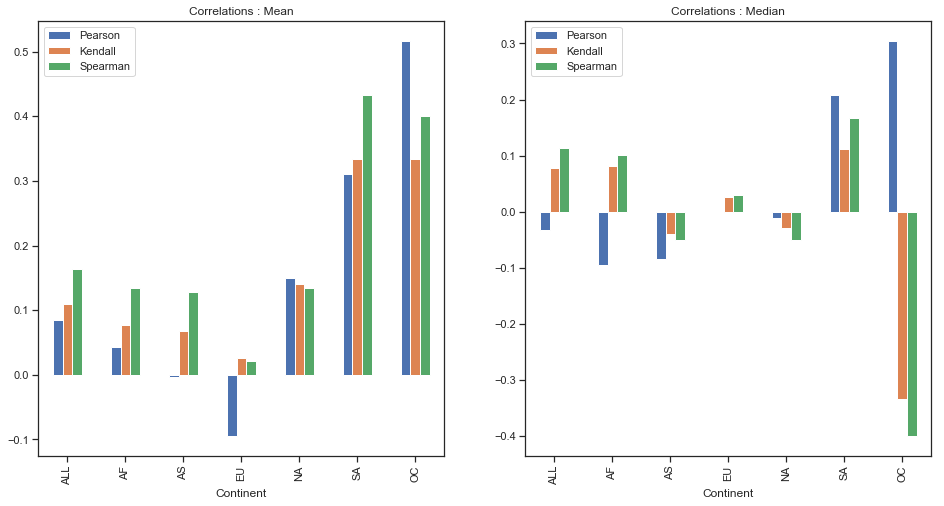

,Continent,Pearson_Mean,Kendall_Mean,Spearman_Mean,Pearson_Median,Kendall_Median,Spearman_Median
0,ALL,0.084831,0.109519,0.164354,-0.033272,0.078645,0.113693
1,AF,0.042811,0.077303,0.134203,-0.094121,0.082336,0.100359
2,AS,-0.002918,0.067797,0.127885,-0.083715,-0.040123,-0.049590
3,EU,-0.095040,0.025659,0.021123,-0.000613,0.025733,0.029447
4,NA,0.149409,0.140859,0.133892,-0.011167,-0.028172,-0.050210
5,SA,0.310564,0.333333,0.433333,0.207760,0.111111,0.166667
6,OC,0.516852,0.333333,0.400000,0.304719,-0.333333,-0.400000


In [91]:
show_corr(mean_overweight, median_overweight, 'Overweight Prevalence', 'fat_100g', 'Mean', 'Median', columns, continent)

In [ ]:
sns_plt(pd.concat(mean_overweight[1:]),pd.concat(median_overweight[1:]), 'Overweight Prevalence', 'sugars_100g', 'continent', 'Mean', 'Median', 'Overweight vs. Sugar')

In [ ]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])

In [ ]:
plot(mean_overweight, median_overweight, continent, 'Mean', 'Median', 'Overweight Prevalence', 'sugars_100g', 'Overweight vs. Sugar', columns)

In [ ]:
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: str(x).lower().replace(' ', '-'))
diab = diab.apply(lambda x: get_tag(x, 'country/territory', 'code', 'continent'), axis=1)

In [ ]:
diab.head()

In [ ]:
# TODO fix this
diab[diab['code'] == 'TBD']

In [ ]:
#remove rows without country codes
diab = diab[diab['code'] != 'TBD']
#set index for more agreable plotting
diab.set_index('code', inplace=True)
diab = diab[diab.index.isin(indexes[0])]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab = diab.rename(columns={'Diabetes [18-99] national prevalence[%]':'Diabetes Prevalence'})
diab.index.name = 'countries_tags'
diab.plot.bar(figsize=(20,5))

In [ ]:
mean_diabetes = merge_all(mean, diab, right_index=True)
median_diabetes = merge_all(median, diab, right_index=True)

In [ ]:
plot(mean_diabetes, median_diabetes, continent, 'Mean', 'Median', 'Diabetes Prevalence', 'fat_100g', 'Diabetes vs. Fat', columns)


In [ ]:
plot(mean_diabetes, median_diabetes, continent, 'Mean', 'Median', 'Diabetes Prevalence', 'sugars_100g', 'Diabetes vs. Sugar', columns)


Like for the obesity : it is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the diabetes percentage display above. Same example : slovakia is in just after the middle but not really for the sugar & fat. Once more that is only a guess we have to provide a scatter plot to proove it.

### Summarize
We selected the datas who have an interest for us. We parse them to be able to get some results from it. We already get some results concerning alimentation quality of different countries. The really next step is to prove if a correlation exists between our results. (We have some guesses, but we have to provide a scatter plot and a correlation coefficient to proove it)

### What comes next

First, we reoriented our approach of our study. 
We decided to globalize our approach and not to focus our work only on the european countries. 
Indeed not too many countries have relevant data so we can include all of them.

We spent a lot of time on cleaning the datasets, so we focused our milestone on the countries part. 
We now will be able to have more relevant results, such as a visualization of the correlation (or not) between features.
We will focus on the food quality in the next steps, such as finding which particular foods have a higher sugar or fat content, instead of just comparing the countries. 

#### Research questions 
As we discussed above we did not yet work on the food quality, so we are not able to answer our research questions for the moment. We have to extract more data and try to find a correlation with the ones we already have. 

### IHD 

In [ ]:
ihd_df = ihd.copy()
ihd['IHD'] = ihd['IHD'].apply(lambda x: x*1000)
ihd['Country'] = ihd['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
ihd = ihd.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
ihd = ihd[ihd['code'] != 'TBD']
ihd = ihd.set_index(['code'])
ihd.head()

In [ ]:
population['Country'] = population['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
population = population.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
population = population[population['code'] != 'TBD']
population = population.set_index(['code'])
population.head()

In [ ]:
pop_ihd = ihd.merge(population, left_index=True, right_index=True)
pop_ihd.drop(columns=['Country_y'], inplace=True)
pop_ihd['IHD_%'] = ""

In [ ]:
#for index, data in pop_ihd.iterrows():
#    data['IHD_%'] = data['IHD'] / data['Population'] * 100
    
def find_percentage(row):
    row['IHD_%'] =  row['IHD'] / row['Population'] * 100
    return row

pop_ihd = pop_ihd.apply(find_percentage, axis=1)
pop_ihd.head()

In [ ]:
def from_2_to_3_country_code(country_tag_2):
    code = countries_infos[countries_infos['COUNTRY_ALPHA2_CODE'] == country_tag_2]['COUNTRY_ALPHA3_CODE'].drop_duplicates()
    if code.size != 1:
        return 'TBD'
    else:
        return code.iloc[0]

In [ ]:
def get_code_from_json(json_object):
    found = re.search('.id.\s*:\s*.(\w\w\w).', json_object, re.IGNORECASE)  
    #print(json_object)
    if found:
        json_object = found.group(1)
    return json_object

In [ ]:
def get_map():
    #countries_infos
    sugar_for_map = sugar.reset_index()
    sugar_for_map['countries_tags'] = sugar_for_map['countries_tags'].apply(lambda x: from_2_to_3_country_code(x))
    sugar_for_map
    
    countries_shapes['features'] = countries_shapes['features'].apply(lambda x: get_code_from_json(str(x)))

    for code in countries_shapes['features']:
        if len(code) != 3:
            continue

        if sugar_for_map[sugar_for_map['countries_tags'] == code].size == 0:
            test = pd.DataFrame(columns=['countries_tags', "sugars_100g"])
            
            dTest = {
                'countries_tags' : code,
                'sugars_100g' : 0
            }
            
            sugar_for_map = sugar_for_map.append(dTest, ignore_index=True)
            
        
            
    # Setup a folium map at a high-level zoom
    map = folium.Map(location=[30, 0], zoom_start=2)

    # choropleth maps bind Pandas Data Frames and json geometries.
    #This allows us to quickly visualize data combinations
    map.choropleth(geo_data=DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, data=sugar_for_map,
                 columns=['countries_tags', 'sugars_100g'],
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name='hist_indicator')
    return map

In [ ]:
sugar_map = get_map()

In [ ]:
sugar_map

### Playground